In [ ]:
from src.loading import load_dataset_subset

dataset_base = r"C:\Users\bianc\Vision\tpf\DETRAC_Upload"

subset = load_dataset_subset(
    base_dir=dataset_base,
    split="train",
    percent=2.0,   # Aca usamos el 2% de trian noma'
    shuffle=True
)

len(subset["image_paths"]), subset["image_paths"][0]



Total imágenes en train: 82085 | Usando: 1641 (2.0%)


(1641,
 WindowsPath('C:/Users/bianc/Vision/tpf/DETRAC_Upload/images/train/MVI_39781_img01502.jpg'))

In [2]:
from src.loading import load_yolo_detector
yolo_model = load_yolo_detector("yolo11s.pt")

Modelo YOLO cargado: yolo11s.pt


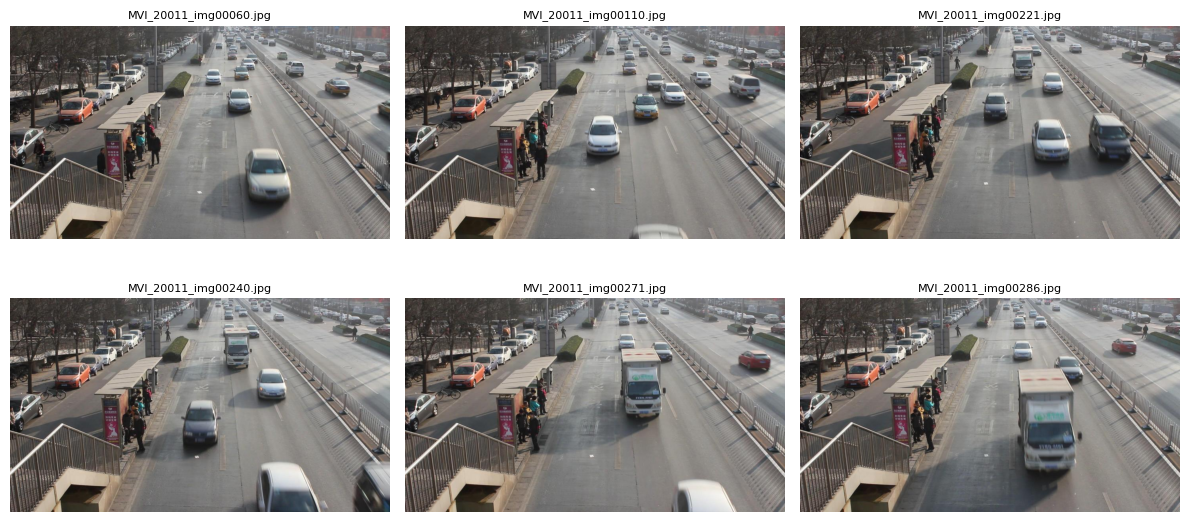

In [ ]:
from src.visualization import preview_sequence_grid

# Mostrar 6 imágenes de la secuencia MVI_20011 en un grid 2x3
preview_sequence_grid(
    image_paths=subset["image_paths"],
    sequence_filter="MVI_20011",  #Aca va None si queres mezclar todas las secuen
    n_rows=2,
    n_cols=3,
    random_sample=False          # True si querés 6 frames al azar
)


Config YOLO creada:
  YAML:   C:\Users\bianc\Vision\tpf\ua_detrac_subset.yaml
  train:  C:\Users\bianc\Vision\tpf\ua_detrac_subset_train.txt (1312 imágenes)
  val:    C:\Users\bianc\Vision\tpf\ua_detrac_subset_val.txt (329 imágenes)
Ultralytics 8.3.228  Python-3.11.2 torch-2.7.0+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\bianc\Vision\tpf\ua_detrac_subset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0

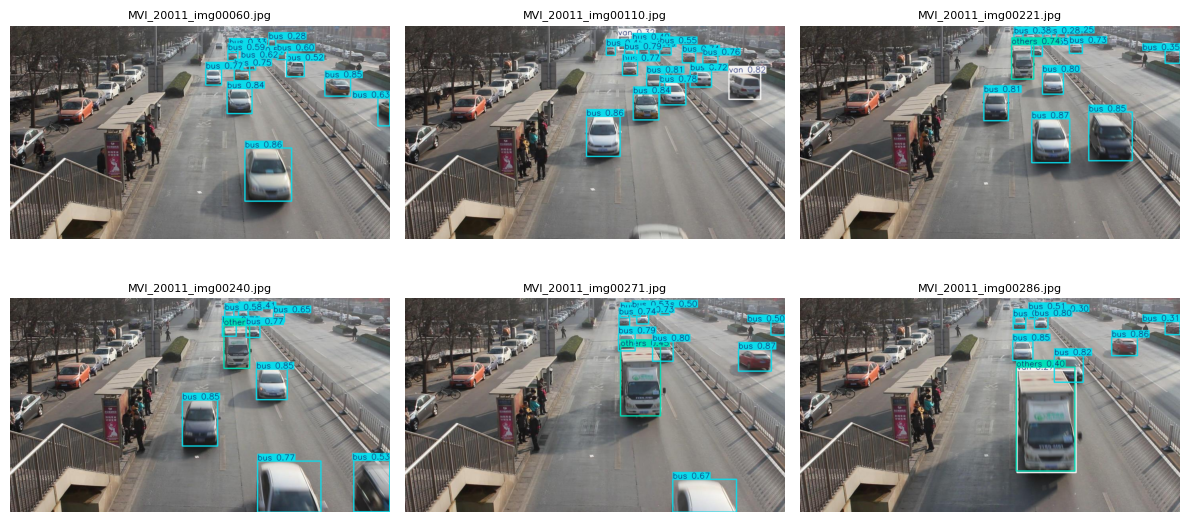

In [ ]:
from pathlib import Path

from src.training import create_yolo_subset_config, finetune_yolo_model
from src.visualization import plot_yolo_predictions_grid

# Ruta donde querés guardar el data.yaml y los .txt de subset
project_root = Path(r"C:\Users\bianc\Vision\tpf")
data_yaml_path = project_root / "ua_detrac_subset.yaml"

# 1) Crear config YOLO para entrenar sólo con el subset actual (2% del train)
yaml_path, train_txt, val_txt = create_yolo_subset_config(
    image_paths=subset["image_paths"],
    yaml_path=data_yaml_path,
    # si querés cambiar el split interno train/val, tocas train_ratio
    train_ratio=0.8,
)

# 2) Fine-tuning rápido (pocas epochs, subset chiquito)
results = finetune_yolo_model(
    model=yolo_model,           # el que cargaste en la celda 1
    data_yaml_path=yaml_path,
    epochs=3,                   # para probar; luego podés subirlo
    imgsz=640,
    batch=4,
    project="runs",
    name="ua_detrac_subset_exp1",
)

# 3) Visualizar cómo quedó el modelo en 6 imágenes de MVI_20011
plot_yolo_predictions_grid(
    model=yolo_model,
    image_paths=subset["image_paths"],
    n_rows=2,
    n_cols=3,
    conf=0.25,
    sequence_filter="MVI_20011",   # o None para mezclar todoooo
)


Esto ya funcina muy bien de por si
El analisis de filtros (suavizar, modificar contraste, etc para mejorar la loss del YOLO) deberia ser con un dataset mas jodido pq este ya lo maneja perfecto
Uno con niebla lluvia o algo asi
https://data.mendeley.com/datasets/766ygrbt8y/1#:~:text=VdiAw%20dataset%20consists%20of%20real,This%20data%20helps
Este tiene buenas fotos pero algunas son de autopistas como otras son desde adentro de un auto, aunque podriamos hacer un analisis de deteccion con esto usando filtros etc